### Amplitue Modulation

This is a test to confirm c is recognized as light speed.[m/s]
299792458.0

t_step [s]
8.00000E-18



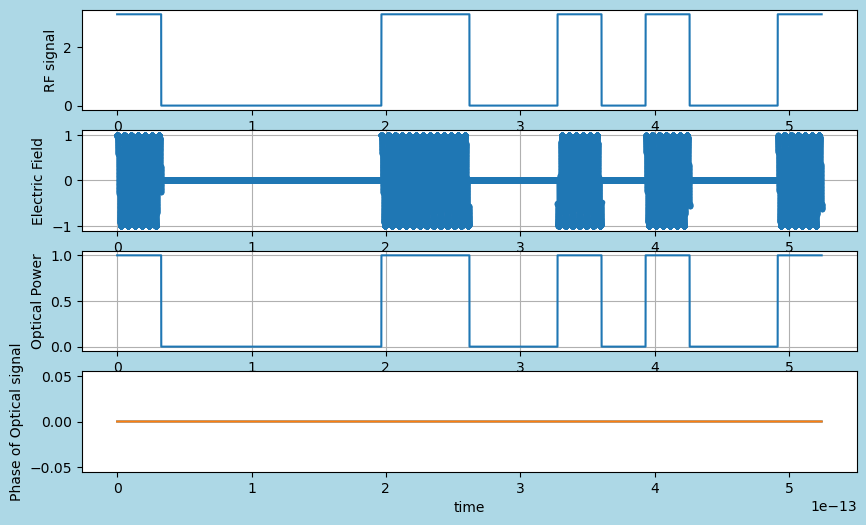

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.constants import c
import cmath

from scipy.signal import butter, lfilter, freqz
from scipy.fftpack import fft, fftshift

import mach_zender_interferometer_time_def
from prbs_def import prbs_1, prbs_2


samplerate = 2 **16 # Number of Points
t_step = 8e-18 #[s]

print("This is a test to confirm c is recognized as light speed.[m/s]")
print(c)
print('')

print("t_step [s]")
print(f'{t_step:.5E}')
print('')

tcol = np.linspace(0.0, t_step * samplerate, samplerate, endpoint=False)

wl1 = 1550e-9 
wl2 = 1550e-9

# If wl1 and wl2 are equal, homodyne. If not, heterodyne.

lightfreq1 = c / wl1
lightfreq2 = c / wl2

signalcol = np.zeros(samplerate)

#amp_c = 0.5*np.pi
#freq_am = 10e12
#md = 1 # modulation depth. 1 = 100 %
#dc_offset = 0.5*np.pi # DC offset
#signalcol = prbs_1(samplerate, a1_range = [0,1], b1_range = [10, 50])
#signalcol = amp_c * np.sin(2 * np.pi * freq_am * tcol) + dc_offset

signalcol =prbs_2(samplerate, numberofpointspersymbol = 16) + 0.5*np.pi


#Ein1 = np.array([[0.707+0.707j],[-0.707-0.707j]])
Ein1 = np.array([[0.707+0.707j],[0-0j]])

oplcommon1=100 #Common Path Length 1
oplcommon2=100 #Common Path Length 2

wl = 1550e-9

opl1 =100 
opl2= 100

PT1 = 0.5 # PT: Power Transmission of first beam splitter
PT2 = 0.5 # PT: Power Transmission of second beam splitter


opl1 = 2*np.pi * lightfreq1 * tcol # phase of local oscillator [rad]


opl2 = 2*np.pi * lightfreq2 * tcol + signalcol # Phase of Modulated Light [rad]    
    



Port1_1_EFcol = np.zeros(samplerate, dtype=complex)
Port1_2_EFcol = np.zeros(samplerate, dtype=complex)

P1_powercol = np.zeros(samplerate)
P1_phasecol = np.zeros(samplerate)

P2_powercol = np.zeros(samplerate)
P2_phasecol = np.zeros(samplerate)

for ii in range(samplerate):
    
    t = tcol[ii]
    phase1 = opl1[ii]
    phase2 = opl2[ii]
    
    Eout1 = mach_zender_interferometer_time_def.propagate1(oplcommon1, oplcommon2, Ein1)
    Ein2 = Eout1
    
    Eout2 = mach_zender_interferometer_time_def.beamsplitter(PT1, Ein2)
    # Beam enter first beam splitter (or Fiber Coupler)
    Ein3 = Eout2
    
    Eout3 = mach_zender_interferometer_time_def.propagate1(phase1, phase2, Ein3)
    # Each path experience different path length
    Ein4 = Eout3
    
    Eout4 = mach_zender_interferometer_time_def.beamsplitter(PT2, Ein4)
    # Each path enter second beam splitter (or Fiber Coupler)
    Ein5 = Eout4
    
    Eout5 = mach_zender_interferometer_time_def.propagate1(oplcommon1, oplcommon2, Ein5)
    Ein6 = Eout5
    
    Eout_port1 = Ein6[0,0]
    Port1_1_EFcol[ii] = Eout_port1
    
    power_11 = (np.abs(Eout_port1))**2 # Optical power is calculated as square of absolute electric field strength
    P1_powercol[ii] = power_11
    
    P1_phase = cmath.phase(power_11)
    P1_phasecol[ii] = P1_phase
    
    Eout_port_2 = Ein6[1,0]
    power_22 = (np.abs(Eout_port_2))**2
    
    P2_powercol[ii] = power_22
    
    P2_phase = cmath.phase(power_22)
    P2_phasecol[ii] = P2_phase
 
 

fig = plt.figure(figsize = (10,6), facecolor='lightblue')

ax1 = fig.add_subplot(4, 1, 1)
ax2 = fig.add_subplot(4, 1, 2)
ax3 = fig.add_subplot(4, 1, 3)
ax4 = fig.add_subplot(4, 1, 4)

ax1.plot(tcol,signalcol)
ax1.set_ylabel("RF signal")
#ax1.set_ylim(-3,3)

#2 Electric Field
ax2.plot(tcol,np.real(Port1_1_EFcol),'.-')

ax2.set_ylabel("Electric Field")
#ax2.set_ylim(0,1.1)
ax2.grid()

# Power
ax3.plot(tcol,P1_powercol)
ax3.set_ylabel("Optical Power")


#ax3.set_ylim(-2,2)
ax3.grid()
    
ax4.plot(tcol,P1_phasecol,tcol,P2_phasecol)
ax4.set_xlabel("time")
ax4.set_ylabel("Phase of Optical signal")

plt.show()